In [1]:
from rubin_sim.scheduler.modelObservatory import Model_observatory
from rubin_sim.scheduler.surveys import BaseSurvey, Scripted_survey
from rubin_sim.scheduler.utils import empty_observation, scheduled_observation
from rubin_sim.scheduler.schedulers import Core_scheduler, simple_filter_sched
from rubin_sim.scheduler import sim_runner

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

In [2]:
# load up a model observatory.
nside=32  # Specify the HEALpix resolution we want to do everything in.
mo = Model_observatory(nside=nside)

In [3]:
conditions = mo.return_conditions()

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:414: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


In [4]:
conditions.mjd

60218.0

In [5]:
help(scheduled_observation)

Help on function scheduled_observation in module rubin_sim.scheduler.utils.utils:

scheduled_observation(n=1)
    Make an array to hold pre-scheduling observations
    
    Returns
    -------
    result : np.array
    
    
    things to fill in
    ------
    mjd_tol : `float`
        The tolerance on how early an observation can execute (days). Observation will be considered valid to attempt
        when mjd-mjd_tol < current MJD < flush_by_mjd (and other conditions below pass)
    dist_tol : `float`
        The angular distance an observation can be away from the specified RA,Dec and
        still count as completing the observation (radians).
    alt_min : `float`
        The minimum altitude to consider executing the observation (radians).
    alt_max : `float`
        The maximuim altitude to try observing (radians).
    HA_max : `float`
        Hour angle limit. Constraint is such that for hour angle running from 0 to 24 hours,
        the target RA,Dec must be greather than HA

In [6]:
# Let's make a few scheduled observations manually, then load them into a scripted survey object
obs = scheduled_observation(10)
obs['RA'] = 0
obs['dec'] = np.radians(-90.)
# Set them to be every 30 minutes, starting 2 hours from current mjd
obs['mjd'] = conditions.mjd + np.arange(10)*0.5/24 + 2./24.
obs['exptime'] = 30
obs['nexp'] = 2
obs['filter'] = 'i'
obs['note'] = 'scripted'
obs['flush_by_mjd'] = conditions.mjd + 10

# This is a little tichy. Need to set these, 
# Otherwise they will not pass if-statements
obs['mjd_tol'] = 10./3600/24.
obs['dist_tol'] = np.radians(3.)
obs['alt_min'] = 0
obs['alt_max'] = np.radians(85.)
# This is effectively no hour angle limit. XXX--need to document better
obs['HA_max'] = 0. # Hours
obs['HA_min'] = 24.

# You can make this array of scheduled observations any way you like! Can be one observations, or lots over years.

In [7]:
# Insatiate a scripted survey object
ss = Scripted_survey([])
# Load our scheduled observations into it
ss.set_script(obs)

In [8]:
# Our friend the SCP survey from previous notebook
class SCP_survey(BaseSurvey):
    """A South Celestial Pole survey"""
    def generate_observations_rough(self, conditions):
        obs = empty_observation()
        obs['RA'] = 0.
        obs['dec'] = np.radians(-87.)
        obs['exptime'] = 30.
        obs['nexp'] = 2
        obs['filter'] = 'r'
        # If it's been 12 hours or more, don't try to execute the observation anymore
        obs['flush_by_mjd'] = conditions.mjd + 0.5
        obs['note'] = 'scp'  # Always good to set the note to which survey generated the observation
        result = [obs] * 3
        return result

In [9]:
scp = SCP_survey([])

In [10]:
# Now, we can run both surveys at the same time. 
# We're loading these as a list-of-lists. If nothing in the first list can provide an observation, the
# scheduler moves onto the next list. This structure helps with computational efficiency--we only compute 
# the scp reward function when we might actually need it. 
scheduler = Core_scheduler([[ss], [scp]], nside=nside)

# It's up to you to make sure you have a robust survey object at the end of your list-of-lists that 
# can execute at any time under any conditions.


In [11]:
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=1.0,
                                                 verbose=True)

progress = 98.37%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 914 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [12]:
# Wow, note now we have 914 observations. Down from 979 before. That's what 10 filter changes in a night will do.
np.unique(observations['note'])

array(['scp', 'scripted'], dtype='<U40')

Text(0, 0.5, 'Altitude (degrees)')

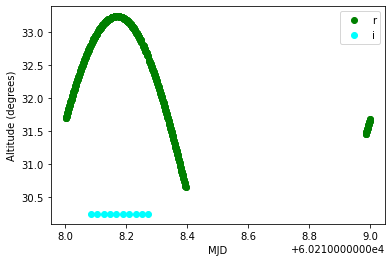

In [13]:
# let's plot and color-code by filter
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')


Keep in mind, that mjd_tol is a tricky parameter. If you make it very large, your observation might execute earlier than you like. Set it small, and your background survey might take too much time and block it out. Here, the SCP survey only generates 3 observations at a time, but other survey objects (like DDFs and contiguous blobs) tend to be longer.

Note on survey objects. 1-10s of survey objects are fine. (baseline simulation currently uses 17 survey objects). But the code is *not* designed to scale up to thousands of survey objects. If you are tempted to generate a decision tree with thoudands of survey objects there's probably a better way to do it.

In [14]:
# Let's run it again but stop 0.1 days in:
scp = SCP_survey([])
ss = Scripted_survey([])
# Need to reset the obs so it doesn't think they have been observed
obs['observed'] = False
ss.set_script(obs)
scheduler = Core_scheduler([[ss], [scp]], nside=nside)
mo = Model_observatory(nside=nside)

mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=0.1,
                                                 verbose=True)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:414: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


progress = 83.84%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 230 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [15]:
# When the conditions object goes into the scheduler object, the Core_scheduler checks ALL the
# survey objects to see if they have any scheduled observations and adds their MJDs to the 
# conditions.scheduled_observations attribute. This make it easier for low tier survey 
# objects to check how much time they have to
# work with and respect the time-slots of upcoming scheduled observations. This is currently the
# only communication that goes on between survey objects.
conditions = mo.return_conditions()
scheduler.update_conditions(conditions)
scheduler.conditions.scheduled_observations

array([60218.10416667, 60218.125     , 60218.14583333, 60218.16666667,
       60218.1875    , 60218.20833333, 60218.22916667, 60218.25      ,
       60218.27083333])